# 1. BUSINESS UNDERSTANDING
The Seattle AirBnB Dataset contains data about AirBnB listings in Seattle, calendar availability for each of these listings as well as user reviews on the listings. Using this dataset, I am going to attempt to answer the following business questions.

1. Understand price increases/decreases by season and detect peak season in Seattle ?
2. what is the relation between neighborhoods , review and price how review and neighborhoods effect on price ?
3. Does accommodates make price higher and what is Top10 neighborhoods that accommodates effect in ?


Price Prediction
Can we predict price for a given listing? What factors of the listing correlate best for predicting price?



# 2. DATA UNDERSTANDING

### There are 3 files i will read them and trying to understanding those data.

In [593]:
# Import statements
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline
import seaborn as sns
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.decomposition import PCA  
from sklearn.preprocessing import StandardScaler

In [594]:
# Read in the calendar data set
df_calendar = pd.read_csv('./seattle/calendar.csv')
df_calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [595]:
# Read in the listings data set
df_listings = pd.read_csv('./seattle/listings.csv')
df_listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [596]:
# Read in the reviews data set
df_reviews = pd.read_csv('./seattle/reviews.csv')
df_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [597]:
def explore(df):
    print(df.head())
    print("shape of dataFrame:")
    print(df.shape)
    # Assess null values
    print("Percentage of missing value in columns:")
    print(df.isnull().sum()/df.shape[0]*100)
    print(df.info())
    most_missing_cols = set(df.columns[df.isnull().mean() > 0.20])
    print(most_missing_cols)
    return df.describe(include='all')


In [598]:
explore(df_calendar)

   listing_id        date available   price
0      241032  2016-01-04         t  $85.00
1      241032  2016-01-05         t  $85.00
2      241032  2016-01-06         f     NaN
3      241032  2016-01-07         f     NaN
4      241032  2016-01-08         f     NaN
shape of dataFrame:
(1393570, 4)
Percentage of missing value in columns:
listing_id     0.000000
date           0.000000
available      0.000000
price         32.938998
dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
listing_id    1393570 non-null int64
date          1393570 non-null object
available     1393570 non-null object
price         934542 non-null object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB
None
{'price'}


,listing_id,date,available,price
count,1.393570e+06,1393570,1393570,934542
unique,NaN,365,2,669
top,NaN,2016-11-06,t,$150.00
freq,NaN,3818,934542,36646
mean,5.550111e+06,NaN,NaN,NaN
std,2.962274e+06,NaN,NaN,NaN
min,3.335000e+03,NaN,NaN,NaN
25%,3.258213e+06,NaN,NaN,NaN
50%,6.118244e+06,NaN,NaN,NaN
75%,8.035212e+06,NaN,NaN,NaN


In [599]:
# By looking to data above will noticed that price column missing 33% of values and overall this df need 
#prepration to use it

In [600]:
explore(df_listings)

        id                           listing_url       scrape_id last_scraped  \
0   241032   https://www.airbnb.com/rooms/241032  20160104002432   2016-01-04   
1   953595   https://www.airbnb.com/rooms/953595  20160104002432   2016-01-04   
2  3308979  https://www.airbnb.com/rooms/3308979  20160104002432   2016-01-04   
3  7421966  https://www.airbnb.com/rooms/7421966  20160104002432   2016-01-04   
4   278830   https://www.airbnb.com/rooms/278830  20160104002432   2016-01-04   

                                  name  \
0         Stylish Queen Anne Apartment   
1   Bright & Airy Queen Anne Apartment   
2  New Modern House-Amazing water view   
3                   Queen Anne Chateau   
4       Charming craftsman 3 bdm house   

                                             summary  \
0                                                NaN   
1  Chemically sensitive? We've removed the irrita...   
2  New modern house built in 2013.  Spectacular s...   
3  A charming apartment that sits at

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
count,3.818000e+03,3818,3.818000e+03,3818,3818,3641,3249,3818,3818,2786,...,3162.000000,3818,0.0,3818,3818,3818,3818,3818,3818.000000,3191.000000
unique,NaN,3818,NaN,1,3792,3478,3119,3742,1,2506,...,NaN,1,NaN,1,2,3,2,2,NaN,NaN
top,NaN,https://www.airbnb.com/rooms/1818768,NaN,2016-01-04,Capitol Hill Apartment,This is a modern fully-furnished studio apartm...,"*Note: This fall, there will be major renovati...",Our space is a mix of a hostel and a home. We ...,none,Wallingford is a mostly-residential neighborho...,...,NaN,f,NaN,WASHINGTON,f,strict,f,f,NaN,NaN
freq,NaN,1,NaN,3818,3,15,14,10,3818,17,...,NaN,3818,NaN,3818,3227,1417,3497,3443,NaN,NaN
mean,5.550111e+06,NaN,2.016010e+13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.452245,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.946307,2.078919
std,2.962660e+06,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.750259,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.893029,1.822348
min,3.335000e+03,NaN,2.016010e+13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.020000
25%,3.258256e+06,NaN,2.016010e+13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.695000
50%,6.118244e+06,NaN,2.016010e+13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.540000
75%,8.035127e+06,NaN,2.016010e+13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,3.000000


In [601]:
# Those columns must be removed from df 
#{'weekly_price',
#'host_about',
#'cleaning_fee', 
#'transit',
# 'host_acceptance_rate', 
# 'neighborhood_overview', 
# 'square_feet', 
# 'notes', 'monthly_price', 'security_deposit', 'license'}
# cause it contain missing values more 20% 

In [602]:
df_listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

In [603]:
df_listings['review_scores_rating'].isnull().sum()

647

In [604]:
df_listings['calculated_host_listings_count'].value_counts()

1     2451
2      575
3      262
4      130
5       70
6       65
37      37
31      36
34      34
11      22
21      21
7       21
9       19
8       19
18      18
15      16
12      12
10      10
Name: calculated_host_listings_count, dtype: int64

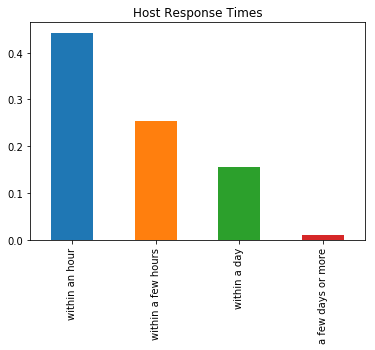

In [605]:
# Explore Categorical Feature - host_response_time
host_response_vals = df_listings['host_response_time'].value_counts()
(host_response_vals/df_listings.shape[0]).plot(kind="bar");
plt.title("Host Response Times");

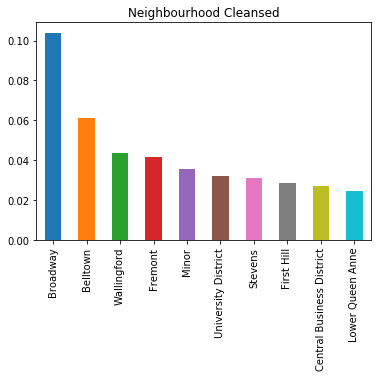

In [606]:
# Explore Categorical Feature - neighborhood_cleansed
neighborhood_vals = df_listings['neighbourhood_cleansed'].value_counts()
(neighborhood_vals[0:10]/df_listings.shape[0]).plot(kind="bar");
plt.title("Neighbourhood Cleansed");

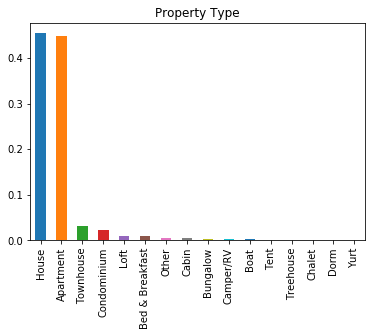

In [607]:
# Explore Categorical Feature - property_type
prop_vals = df_listings['property_type'].value_counts()
(prop_vals/df_listings.shape[0]).plot(kind="bar");
plt.title("Property Type");

In [608]:
explore(df_reviews)

   listing_id        id        date  reviewer_id reviewer_name  \
0     7202016  38917982  2015-07-19     28943674        Bianca   
1     7202016  39087409  2015-07-20     32440555         Frank   
2     7202016  39820030  2015-07-26     37722850           Ian   
3     7202016  40813543  2015-08-02     33671805        George   
4     7202016  41986501  2015-08-10     34959538          Ming   

                                            comments  
0  Cute and cozy place. Perfect location to every...  
1  Kelly has a great room in a very central locat...  
2  Very spacious apartment, and in a great neighb...  
3  Close to Seattle Center and all it has to offe...  
4  Kelly was a great host and very accommodating ...  
shape of dataFrame:
(84849, 6)
Percentage of missing value in columns:
listing_id       0.000000
id               0.000000
date             0.000000
reviewer_id      0.000000
reviewer_name    0.000000
comments         0.021214
dtype: float64
<class 'pandas.core.frame.DataF

,listing_id,id,date,reviewer_id,reviewer_name,comments
count,8.484900e+04,8.484900e+04,84849,8.484900e+04,84849,84831
unique,NaN,NaN,1930,NaN,14380,84136
top,NaN,NaN,2015-09-21,NaN,David,The host canceled this reservation the day bef...
freq,NaN,NaN,580,NaN,870,57
mean,3.005067e+06,3.058765e+07,NaN,1.701301e+07,NaN,NaN
std,2.472877e+06,1.636613e+07,NaN,1.353704e+07,NaN,NaN
min,4.291000e+03,3.721000e+03,NaN,1.500000e+01,NaN,NaN
25%,7.946330e+05,1.725127e+07,NaN,5.053141e+06,NaN,NaN
50%,2.488228e+06,3.228809e+07,NaN,1.413476e+07,NaN,NaN
75%,4.694479e+06,4.457648e+07,NaN,2.762402e+07,NaN,NaN


# 3. DATA PREPARATION

Questions

PRICE ANALYSIS
1. Understand price increases/decreases by season and detect peak season in Seattle ?
2. what is the relation between neighborhoods , review and price how review and neighborhoods effect on price ?
3. Does accommodates make price higher and what is Top10 neighborhoods that accommodates effect in ?

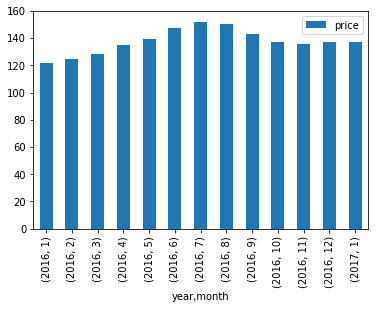

In [609]:
# Solution # 1 for Q -1 
# Plot the average price by month 
df_calendar['year'] = pd.DatetimeIndex(df_calendar['date']).year
df_calendar['month'] = pd.DatetimeIndex(df_calendar['date']).month

# In order to average price, we will be converting it to float and removing the $ sign
df_calendar['price'] = df_calendar['price'].replace('[\$,]', '', regex=True).astype(float)

df_calendar.groupby(['year','month'])[['price']].mean().plot(kind="bar");


By looking above we noticed that start of month 6,7 and 8 the peak are highest 

In [610]:
# Solution # 2 for Q - 2
# Plot the average price by neighborhood

# In order to average price, we will be converting it to float and removing the $ sign
df_listings['price'] = df_listings['price'].replace('[\$,]', '', regex=True).astype(float)

print(df_listings.groupby(['neighbourhood_cleansed','review_scores_rating'])[['price']].mean().sort_values(by='price',ascending=False))

                                                  price
neighbourhood_cleansed review_scores_rating            
Westlake               98.0                  775.000000
Portage Bay            94.0                  750.000000
Eastlake               60.0                  600.000000
Portage Bay            85.0                  525.000000
West Woodland          84.0                  435.000000
Montlake               99.0                  432.500000
Westlake               76.0                  400.000000
Windermere             90.0                  400.000000
West Queen Anne        85.0                  390.000000
Briarcliff             95.0                  375.000000
Pike-Market            99.0                  357.000000
Southeast Magnolia     96.0                  344.500000
Ravenna                76.0                  325.000000
Madrona                93.0                  322.500000
Industrial District    90.0                  320.000000
Loyal Heights          88.0                  305

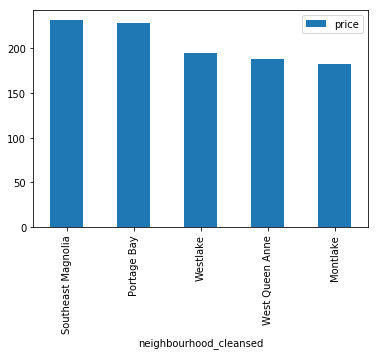

In [611]:
# # Solution # 3 for Q - 3 but in this case i tried to discover top 5 neighborhoods 
# before noticed accommodates how will change ranks of accommodates

# Plot top 5 neighborhoods
top10_neigh = df_listings.groupby(['neighbourhood_cleansed'])[['price']].mean().sort_values(by='price',ascending=False).head()
top10_neigh.plot(kind='bar');

In [612]:
# Solution # 3 for Q - 3 
df_neigh_type = df_listings.groupby(['neighbourhood_cleansed','property_type','accommodates','calculated_host_listings_count'])[['price']].mean().reset_index().sort_values(by='price',ascending=False)
df_neigh_type[0:10]

,neighbourhood_cleansed,property_type,accommodates,calculated_host_listings_count,price
1455,West Queen Anne,House,11,2,975.0
111,Belltown,Apartment,10,1,899.0
1491,Westlake,Boat,8,1,775.0
930,Montlake,House,9,2,750.0
123,Belltown,Condominium,8,3,700.0
1454,West Queen Anne,House,10,1,700.0
1391,Wallingford,Boat,6,1,680.0
236,Broadway,House,16,9,673.0
361,East Queen Anne,House,7,1,600.0
382,Eastlake,House,8,1,600.0


## Question 3 - PRICE PREDICTION

1. Predict price for a given listing. 

In [613]:
# Check if price has missing values, if it does, we want to remove those records from the dataset
df_listings['price'].isnull().sum()

0

In [614]:
# Drop columns that are less likely to have an impact on price
df_list = df_listings.copy()
less_impact = ['id','listing_url','scrape_id','last_scraped','thumbnail_url','medium_url','xl_picture_url','host_id','host_url','host_thumbnail_url','host_verifications','street','neighbourhood','neighbourhood_group_cleansed','zipcode','smart_location','country','latitude','longitude','weekly_price','monthly_price','calendar_updated','calendar_last_scraped','first_review','last_review','calculated_host_listings_count','reviews_per_month']
df_list = df_list.drop(less_impact, axis=1)
df_list.shape

(3818, 65)

In [615]:
# Drop license column
df_list = df_list.drop('license', axis=1)
df_list.shape

(3818, 64)

In [616]:
# Review all the numerical columns and assess missing values

num_cols = df_list.select_dtypes(include=['float', 'int']).columns
for col in num_cols:
    print(col,df_list[col].isnull().sum())

host_listings_count 2
host_total_listings_count 2
accommodates 0
bathrooms 16
bedrooms 6
beds 1
square_feet 3721
price 0
guests_included 0
minimum_nights 0
maximum_nights 0
availability_30 0
availability_60 0
availability_90 0
availability_365 0
number_of_reviews 0
review_scores_rating 647
review_scores_accuracy 658
review_scores_cleanliness 653
review_scores_checkin 658
review_scores_communication 651
review_scores_location 655
review_scores_value 656


In [617]:
# Set 0 for bathroom where bathroom is Nan
df_list['bathrooms'] = df_list['bathrooms'].fillna(0)

# Set 1 for bedrooms where bedrooms is Nan
df_list['bedrooms'] = df_list['bedrooms'].fillna(1)

# Set 1 for beds where beds is Nan
df_list['beds'] = df_list['beds'].fillna(1)

# Drop square_feet column
df_list = df_list.drop('square_feet',axis=1)

# Set all review scores columns with 0 for Nan values
cols_fillna_0 = ['review_scores_rating',
                 'review_scores_accuracy',
                 'review_scores_cleanliness',
                 'review_scores_checkin',
                 'review_scores_communication',
                 'review_scores_location',
                 'review_scores_value']
for col in cols_fillna_0:
    df_list[col] = df_list[col].fillna(0)

# Set host_listings_count and host_total_listings_count to 1
df_list['host_listings_count'] = df_list['host_listings_count'].fillna(1)
df_list['host_total_listings_count'] = df_list['host_total_listings_count'].fillna(1)

In [618]:
# Review all the categorical columns and assess missing values

cat_cols = df_list.select_dtypes(include=['object']).columns
for col in cat_cols:
    
    print(col,df_list[col].isnull().sum())


name 0
summary 177
space 569
description 0
experiences_offered 0
neighborhood_overview 1032
notes 1606
transit 934
picture_url 0
host_name 2
host_since 2
host_location 8
host_about 859
host_response_time 523
host_response_rate 523
host_acceptance_rate 773
host_is_superhost 2
host_picture_url 2
host_neighbourhood 300
host_has_profile_pic 2
host_identity_verified 2
neighbourhood_cleansed 0
city 0
state 0
market 0
country_code 0
is_location_exact 0
property_type 1
room_type 0
bed_type 0
amenities 0
security_deposit 1952
cleaning_fee 1030
extra_people 0
has_availability 0
requires_license 0
jurisdiction_names 0
instant_bookable 0
cancellation_policy 0
require_guest_profile_picture 0
require_guest_phone_verification 0


In [619]:
df_list.shape

(3818, 63)

In [620]:
cols=['name', 'summary', 'space', 'description', 'experiences_offered',
       'neighborhood_overview', 'notes', 'transit', 'picture_url', 'host_name',
       'host_since', 'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_picture_url', 'host_neighbourhood', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_cleansed', 'city', 'state',
       'market', 'country_code', 'is_location_exact', 'property_type',
       'room_type', 'bed_type', 'amenities', 'security_deposit',
       'cleaning_fee', 'extra_people', 'has_availability', 'requires_license',
       'jurisdiction_names', 'instant_bookable', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification']

In [621]:
#Remove all string columns from the dataset cause it has many null value and need more cleansing to put it in model. 

for col in cols:
    df_list.drop(col,axis=1,inplace=True)


In [622]:
# Build out X and y, y to be price column and X to be all the other columns
y = df_list['price']
X = df_list.drop(['price'], axis=1)

In [623]:
# Apply feature scaling
normalizer = StandardScaler()
df_ss = normalizer.fit_transform(X)


In [624]:
# Apply PCA to the data.
pca = PCA()
df_pca = pca.fit_transform(df_ss)

In [625]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca = PCA(n_components=21)
df_pca = pca.fit_transform(df_ss)

In [626]:
# Create train and test data sets
X_train, X_test, y_train, y_test = train_test_split(df_pca, y, test_size = .30, random_state=42) 

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2672, 21) (2672,)
(1146, 21) (1146,)


In [627]:
# Get Dummies for categorical fields
#cat_fields = df_list.select_dtypes(include=['object']).columns

# df_list = pd.get_dummies(df_list, columns=cat_fields)
# df_list.head()

In [628]:
# Instantiate linear regression model and fit it to training data set
lm_model =LinearRegression()
lm_model.fit(X_train, y_train) 
        
# Predict and score the model
y_train_preds = lm_model.predict(X_train)
y_test_preds = lm_model.predict(X_test) 
train_score = sqrt(mean_squared_error(y_train, y_train_preds))#r2_score(y_train, y_train_preds)
test_score = sqrt(mean_squared_error(y_test, y_test_preds))#r2_score(y_test,y_test_preds)
print("The rsquared score on the training data was {}.  The rsquared score on the test data was {}.".format(train_score, test_score))

The rsquared score on the training data was 63.71268679743626.  The rsquared score on the test data was 64.77881592694028.
